# Matrix Profile

## Introduction

The Matrix Profile is a methodology that is in the family of changepoint methodologies. These methodologies are interesting when one has a time-series and one wishes to know if there are specific anomalies and/or regime changes. It is particularly intersesting because the Matrix Profile is non-parametric and makes no assumptions on the underlying distribution. Instead it relies on very intuitive notions of similarity and distance. As such it does not detect mean or variance changes, but shape and pattern changes.

The Matrix Profile works by systematically calculating the shortest Euclidian distances for all segments of a given window size across the whole time-series. The calculations identify where the closest pattern is located and what is the distance. This allows to search for the patterns that have the largest difference, that is, the patterns that represent anomalies. Using the matrix profile, it is also possible to detect regime changes with the FLUSS/FLOSS algorithms.

This notebook explores the ideas of the Matrix Profile with the [Stumpy implementation](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) and tests them out on both simulated and real data.

## Setup

In [1]:
import pandas as pd
import numpy as np
import stumpy
import seaborn as sns
import matplotlib.pylab as plt
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [2]:
sns.set(rc={"figure.figsize": (20, 10)})

## Simulated data

### Sinusoidal data
We generate sinusoidal data in order to mimic a seasonal process:

In [3]:
divs = 10
x = np.arange(start=-4 * np.pi, stop=4 * np.pi, step=np.pi/divs)
y = np.sin(x)

Then we run the matrix profile algorithm on that data:

In [4]:
mp = stumpy.stump(y, m=divs)

/home/lsilvest/miniconda3/lib/python3.9/site-packages/stumpy/core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)


`stump` returns a numpy array with the following columns:
- column 0: the matrix profile (i.e. the z-scored distance)
- column 1: matrix profile indices
- column 2: left matrix profile indices
- column 3: right matrix profile indices

In [5]:
mp[0:10]

array([[0.0, 40, -1, 40],
       [0.0, 41, -1, 41],
       [0.0, 22, -1, 22],
       [0.0, 23, -1, 23],
       [0.0, 24, 0, 24],
       [0.0, 25, 1, 25],
       [0.0, 26, 2, 26],
       [0.0, 27, 3, 27],
       [0.0, 48, 4, 48],
       [0.0, 29, 5, 29]], dtype=object)

We now plot the data together with the matrix profile underneath; since the data is perfectly similar, the matrix profile is always 0, which is why nothing appears in the lower half of the graph.

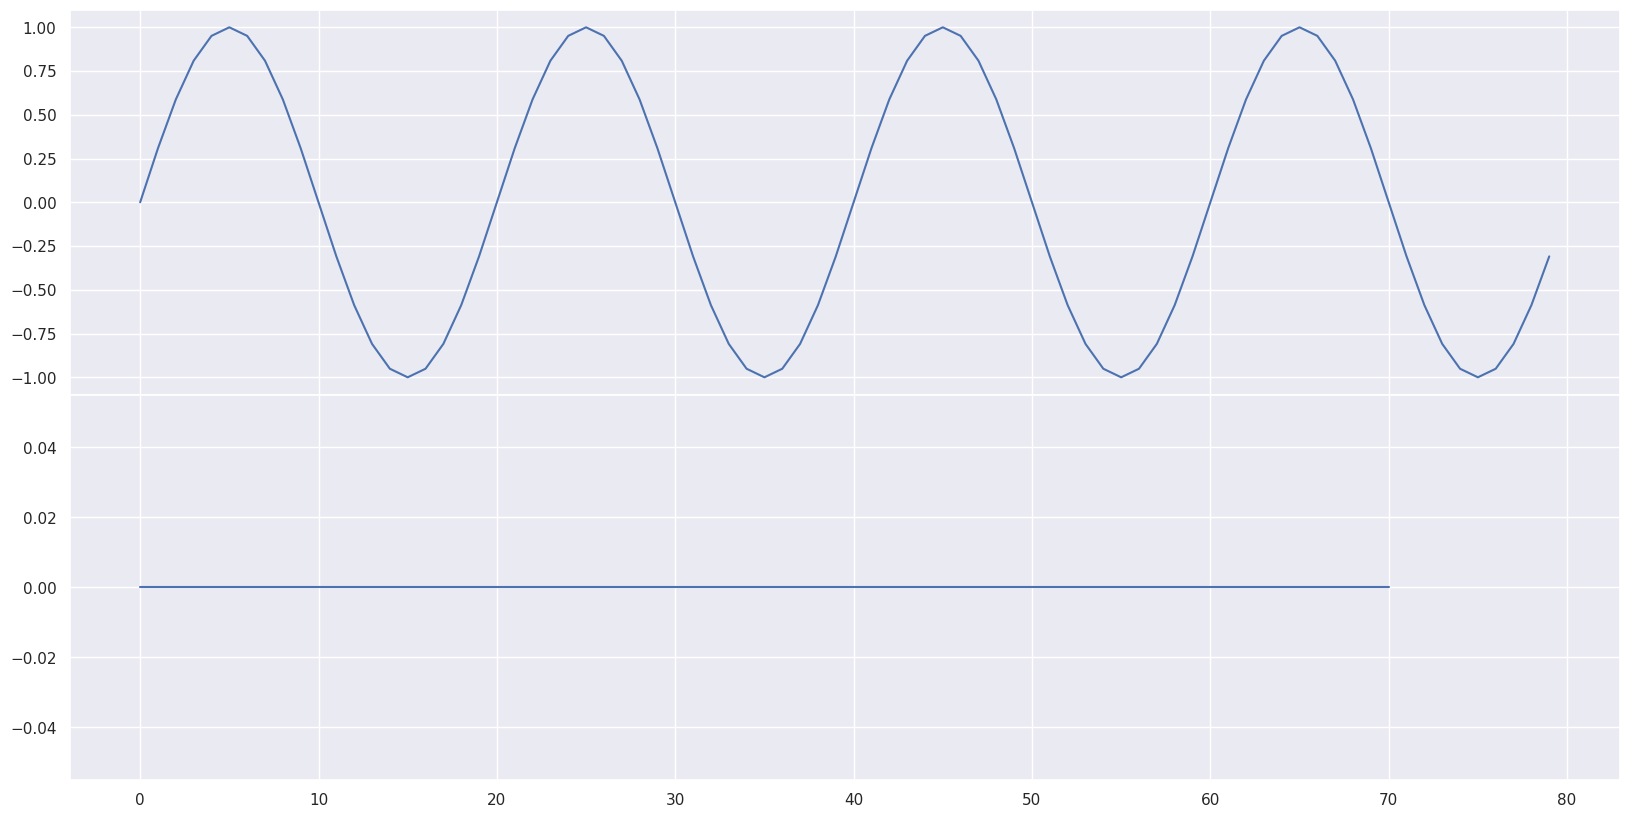

In [6]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(y)
axs[1].plot(mp[:, 0])
plt.show()

We now introduce sone noise in our sinusoidal process:

In [7]:
divs = 20
x = np.arange(start=-4 * np.pi, stop=4 * np.pi, step=np.pi/divs)
ys = np.sin(x)
e = np.concatenate([np.zeros(int(x.shape[0]/2)), 
                    np.random.normal(loc=0.0, scale=0.1, size=x.shape[0]-int(x.shape[0]/2))])
y = ys + e

And recalculate the matrix profile:

In [8]:
mp = stumpy.stump(y, m=divs)

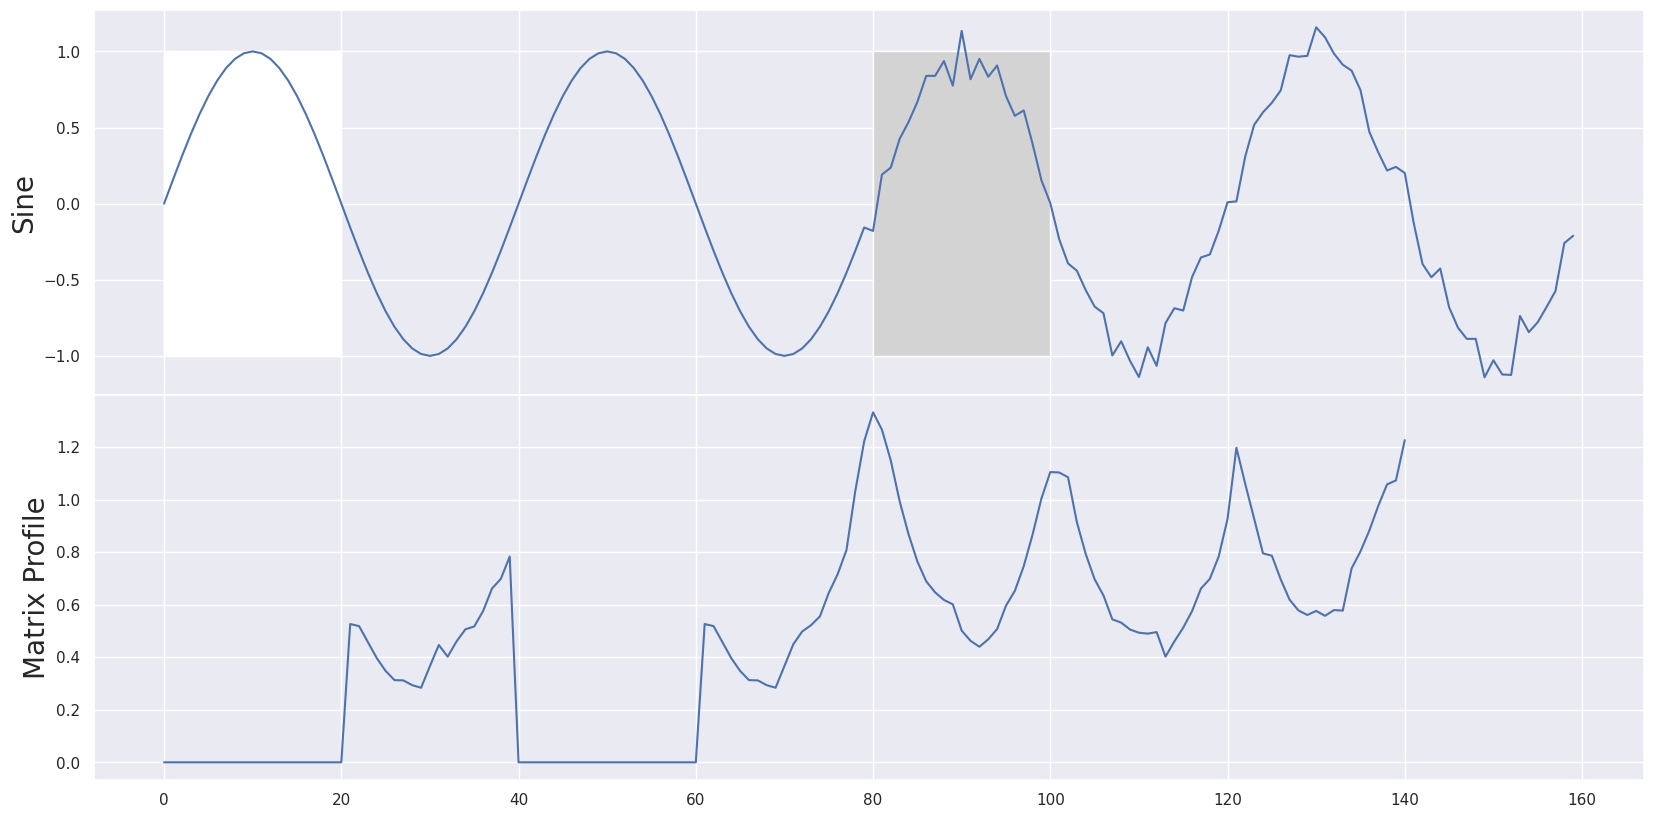

In [9]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(y)
axs[0].set_ylabel('Sine', fontsize='20')

rect = Rectangle((80, -1), divs, 2, facecolor='lightgrey')
axs[0].add_patch(rect)

rect = Rectangle((mp[80, 1], -1), divs, 2, facecolor='white')
axs[0].add_patch(rect)

axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp[:, 0])
plt.show()


The white rectangle represents the closest neighbour to the grey rectangle. It is 39 and hence not exactly aligned with the sine, because the added noise happens to make the non-aligned segment closer.

The reason we see the waves is that the distance is the z-scored Euclidian distance and not the straight Euclidian distance. The normalization when the curve is all positive (or negative) is going to yield higher variance, and so at equal noise, these regions will have a lower z-scored distance. This is in fact an issue, see for instance [Implications of Z-Normalization in the Matrix Profile, De Paepe et al. 2019](https://core.ac.uk/download/pdf/287941767.pdf).

To illustrate how the algorithm works, we calculate the z-scored Euclidian distance at the peak of 80 and the bottom of 90. The formula is:
$$D_{ze}(X, Y) = \sqrt{\sum_{i=1}^{m} \left( \frac{x_i - \mu_X}{\sigma_X} - \frac{y_i - \mu_Y}{\sigma_Y} \right)^2}$$

In [10]:
mp[80]

array([1.332143976616551, 0, 0, 120], dtype=object)

In [11]:
np.sqrt(np.sum((stats.zscore(y[80:100]) - stats.zscore(y[0:20]))**2))

1.3321439766165495

In [12]:
mp[90]

array([0.5011361395164902, 10, 10, 130], dtype=object)

In [13]:
np.sqrt(np.sum((stats.zscore(y[90:110]) - stats.zscore(y[10:30]))**2))

0.5011361395164996

### Non-seasonal

We now turn our attention to non-seasonal data. In particular we are interested in what the matrix profile can do for us in a classical case where we have period of differing means.

In [14]:
def generate_data(period_lengths, means, variances):
    res = pd.DataFrame()
    for l, mu, sigma in zip(period_lengths, means, variances):
        period = pd.DataFrame({'name': [f'({mu},{sigma})'] * l, 
                               'y': np.random.normal(loc=mu, scale=sigma, size=l)})
        res = pd.concat([res, period])
    return res

In [15]:
data = generate_data([100,200,150], [1, 7, 4], [1, 1, 1])
data

,name,y
0,"(1,1)",1.282711
1,"(1,1)",-0.308592
2,"(1,1)",0.601061
3,"(1,1)",2.449113
4,"(1,1)",1.318709
...,...,...
145,"(4,1)",5.788200
146,"(4,1)",4.002776
147,"(4,1)",4.020719
148,"(4,1)",3.121223


In [16]:
mp = stumpy.stump(data.y, m=25)

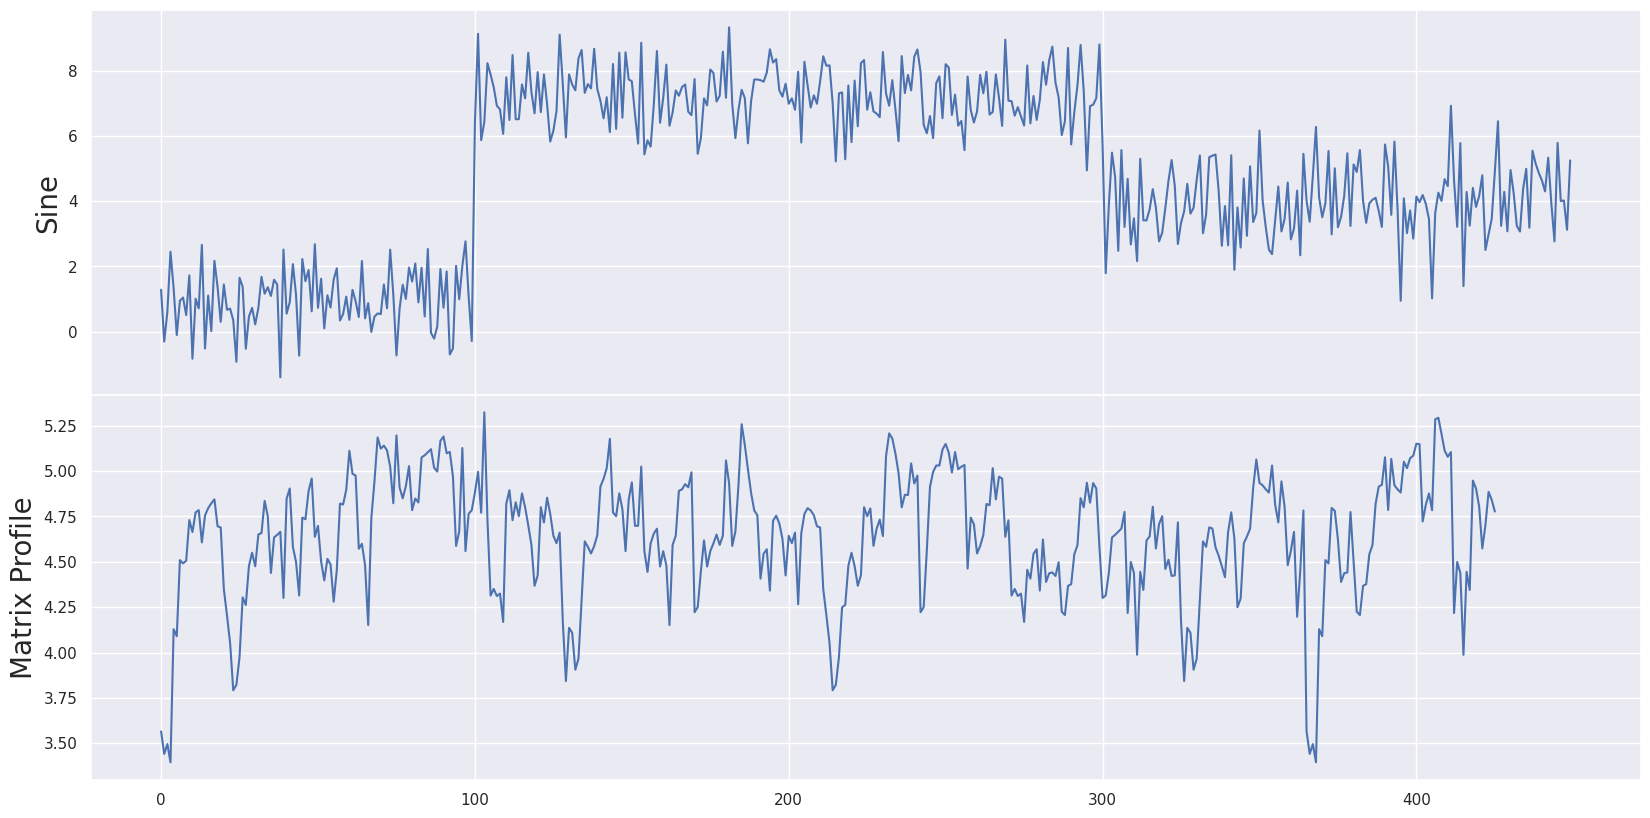

In [17]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(data.y.values)
axs[0].set_ylabel('Sine', fontsize='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp[:, 0])
plt.show()

Note that even so we have a history at a higher mean, that period in itself does not have larger matrix profile values. That is the case first because our window is small compared to the noise and second because the Matrix Profile z-scoring cares about shape and sets means to 0 and variances to 1. This shows that the window must be chosen carefully, and that long mean or variance deviations will not immediately appear in the matrix profile.

# Real data example - counts of death and select causes

## A view of the data

The [Weekly Counts of Death by Jurisdiction and Select Causes of Death](https://catalog.data.gov/dataset/weekly-counts-of-death-by-jurisdiction-and-cause-of-death) is a government data set that aggregates select causes of death from the various states. Likely to preserve the continuity with previous statistics, it does not list COVID-19 as a cause of death, but the prevalent accompanying comorbidity.

At any rate, we use the total count anyway, and try to see if using the matrix profile we can spot anomalies or  regime changes in the mortality that could be due to COVID-19.

In [18]:
wc = pd.read_csv("~/Downloads/Weekly_Counts_of_Death_by_Jurisdiction_and_Select_Causes_of_Death(2).csv")
wc['Week Ending Date'] = wc['Week Ending Date'].astype('datetime64[ns]')

In [19]:
wc

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
2,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
4,Alabama,2017-01-07,AL,2017,1,Alzheimer disease and dementia,96,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475835,Wisconsin,2018-12-29,WI,2018,52,Respiratory diseases,27,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Unweighted
475836,Wisconsin,2019-12-28,WI,2019,52,Respiratory diseases,23,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)
475837,Wisconsin,2019-12-28,WI,2019,52,Respiratory diseases,23,Other diseases of the respiratory system,2015-2019,NaN,NaN,25,NaN,NaN,Unweighted
475838,Wisconsin,2021-01-02,WI,2020,53,Respiratory diseases,15,Other diseases of the respiratory system,2020,NaN,NaN,15,-4.0,-16.7,Predicted (weighted)


In [20]:
wc['Cause Group'].unique()

array(['Alzheimer disease and dementia', 'Circulatory diseases',
       'Malignant neoplasms', 'Other select causes',
       'Respiratory diseases'], dtype=object)

In [21]:
wc_group = wc[wc.Type=="Unweighted"].groupby(
    ['Year', 'Week Ending Date', 'Cause Group']
).agg({'Number of Deaths' : 'sum'}).reset_index()

In [22]:
wc_circ = wc_group[(wc_group['Cause Group'] =="Circulatory diseases")]
wc_resp = wc_group[(wc_group['Cause Group'] =="Respiratory diseases")]

In [23]:
wc_circ

,Year,Week Ending Date,Cause Group,Number of Deaths
1,2015,2015-01-10,Circulatory diseases,38866
6,2015,2015-01-17,Circulatory diseases,38081
11,2015,2015-01-24,Circulatory diseases,36395
16,2015,2015-01-31,Circulatory diseases,35525
21,2015,2015-02-07,Circulatory diseases,36279
...,...,...,...,...
2216,2023,2023-07-08,Circulatory diseases,31684
2221,2023,2023-07-15,Circulatory diseases,30627
2226,2023,2023-07-22,Circulatory diseases,29821
2231,2023,2023-07-29,Circulatory diseases,28525


<Axes: xlabel='Week Ending Date', ylabel='Number of Deaths'>

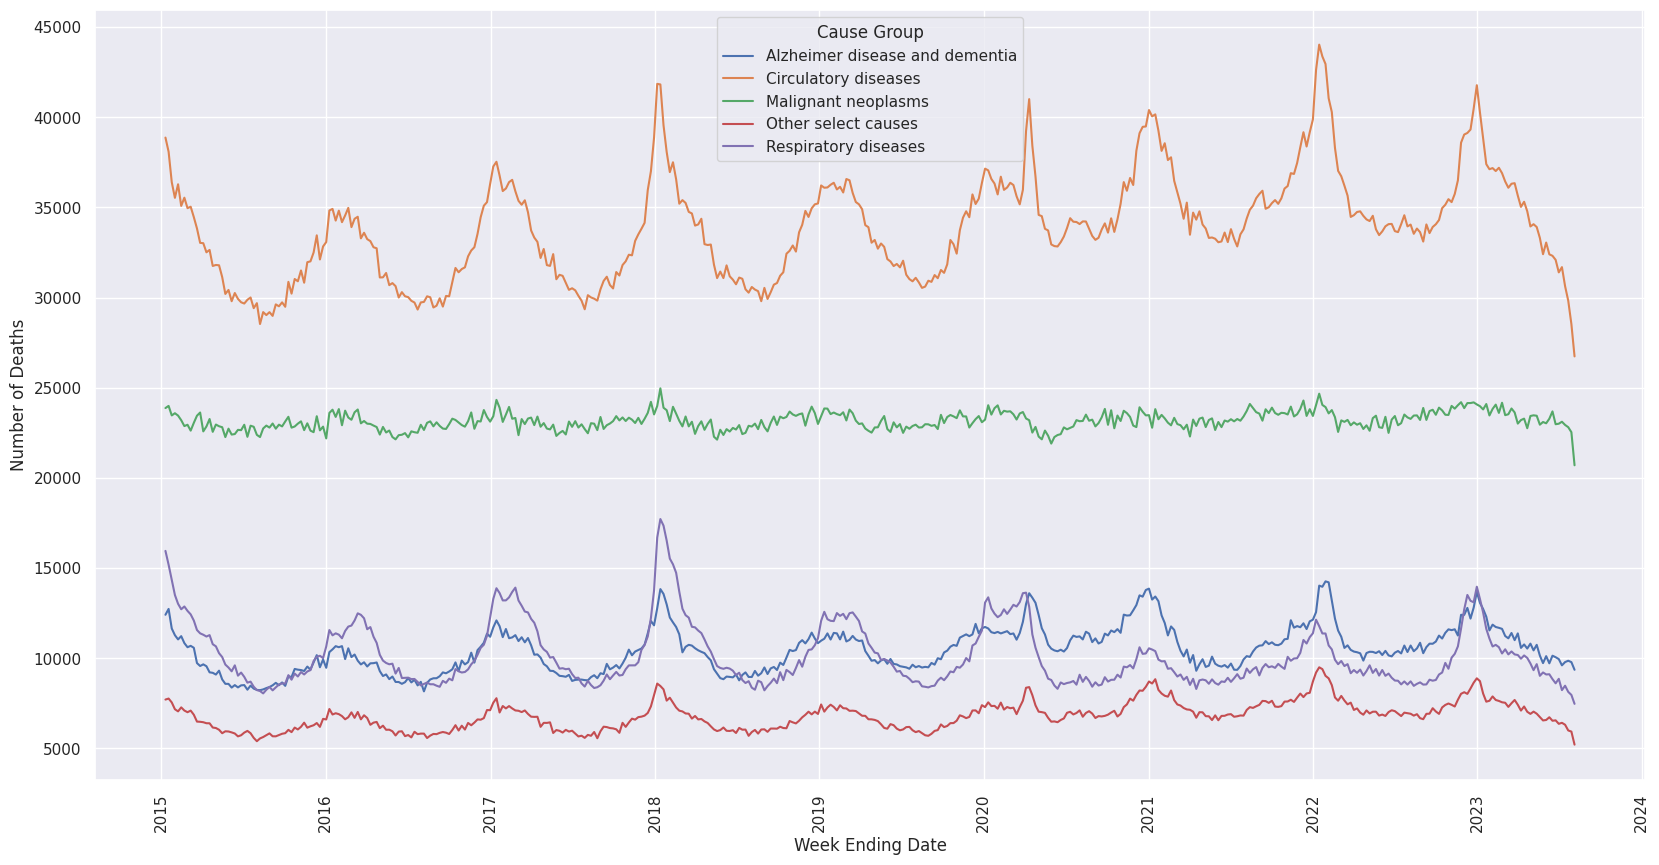

In [24]:
plt.xticks(rotation=90)
sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_group, hue='Cause Group')

<Axes: title={'center': 'All causes'}, xlabel='Week Ending Date', ylabel='Number of Deaths'>

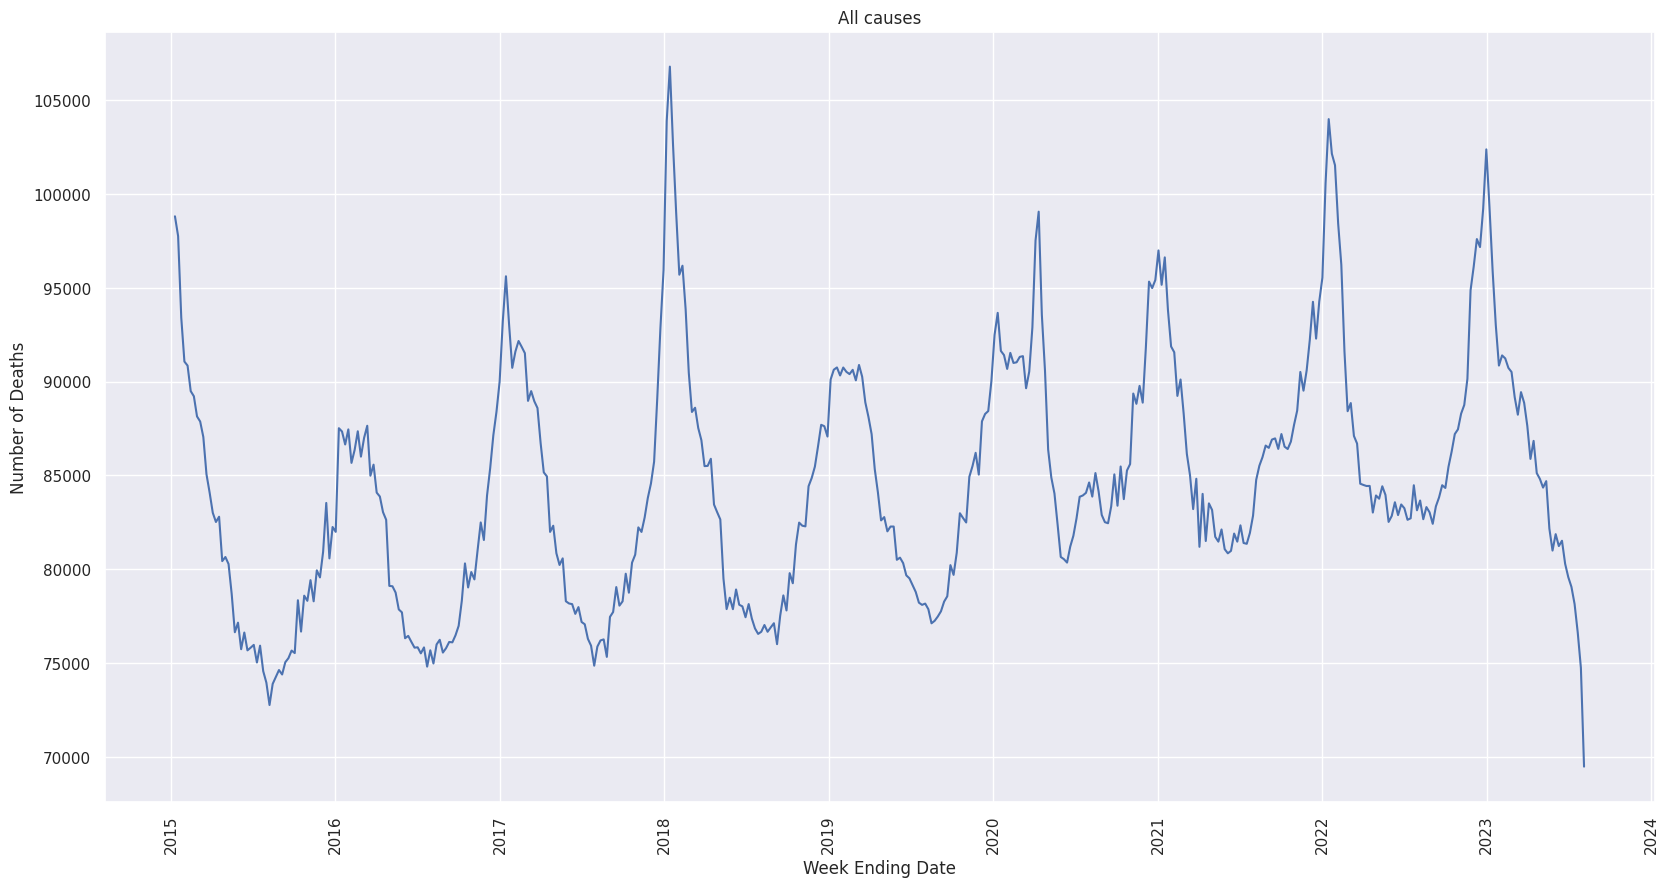

In [25]:
wc_all = wc[wc.Type=="Unweighted"].groupby(
    ['Year', 'Week Ending Date']
).agg({'Number of Deaths' : 'sum'}).reset_index()
plt.xticks(rotation=90)
plt.title('All causes')
sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all)

In [26]:
# cut the end off because it appears there's a data anomaly (maybe a delay in reporting):
wc_all = wc_all[wc_all['Week Ending Date'] < '2023-04-01'].copy()
wc_all

,Year,Week Ending Date,Number of Deaths
0,2015,2015-01-10,98811
1,2015,2015-01-17,97758
2,2015,2015-01-24,93409
3,2015,2015-01-31,91069
4,2015,2015-02-07,90854
...,...,...,...
424,2023,2023-02-25,90514
425,2023,2023-03-04,89173
426,2023,2023-03-11,88238
427,2023,2023-03-18,89440


## Matrix profile

In [27]:
window_size = 52
wc_all['Number of Deaths'] = wc_all['Number of Deaths'].astype('float64')
matrix_profile = stumpy.stump(wc_all['Number of Deaths'], m=window_size)

In [28]:
matrix_profile_df = pd.DataFrame(matrix_profile)
matrix_profile_df['Week Ending Date'] = wc_all.loc[0:(matrix_profile_df.shape[0]+1), 'Week Ending Date']
matrix_profile_df

,0,1,2,3,Week Ending Date
0,1.484866,156,-1,156,2015-01-10
1,1.59379,157,-1,157,2015-01-17
2,1.730295,158,-1,158,2015-01-24
3,1.733147,159,-1,159,2015-01-31
4,1.715434,160,-1,160,2015-02-07
...,...,...,...,...,...
373,2.143108,116,116,-1,2022-03-05
374,2.146645,117,117,-1,2022-03-12
375,2.135886,118,118,-1,2022-03-19
376,2.12099,119,119,-1,2022-03-26


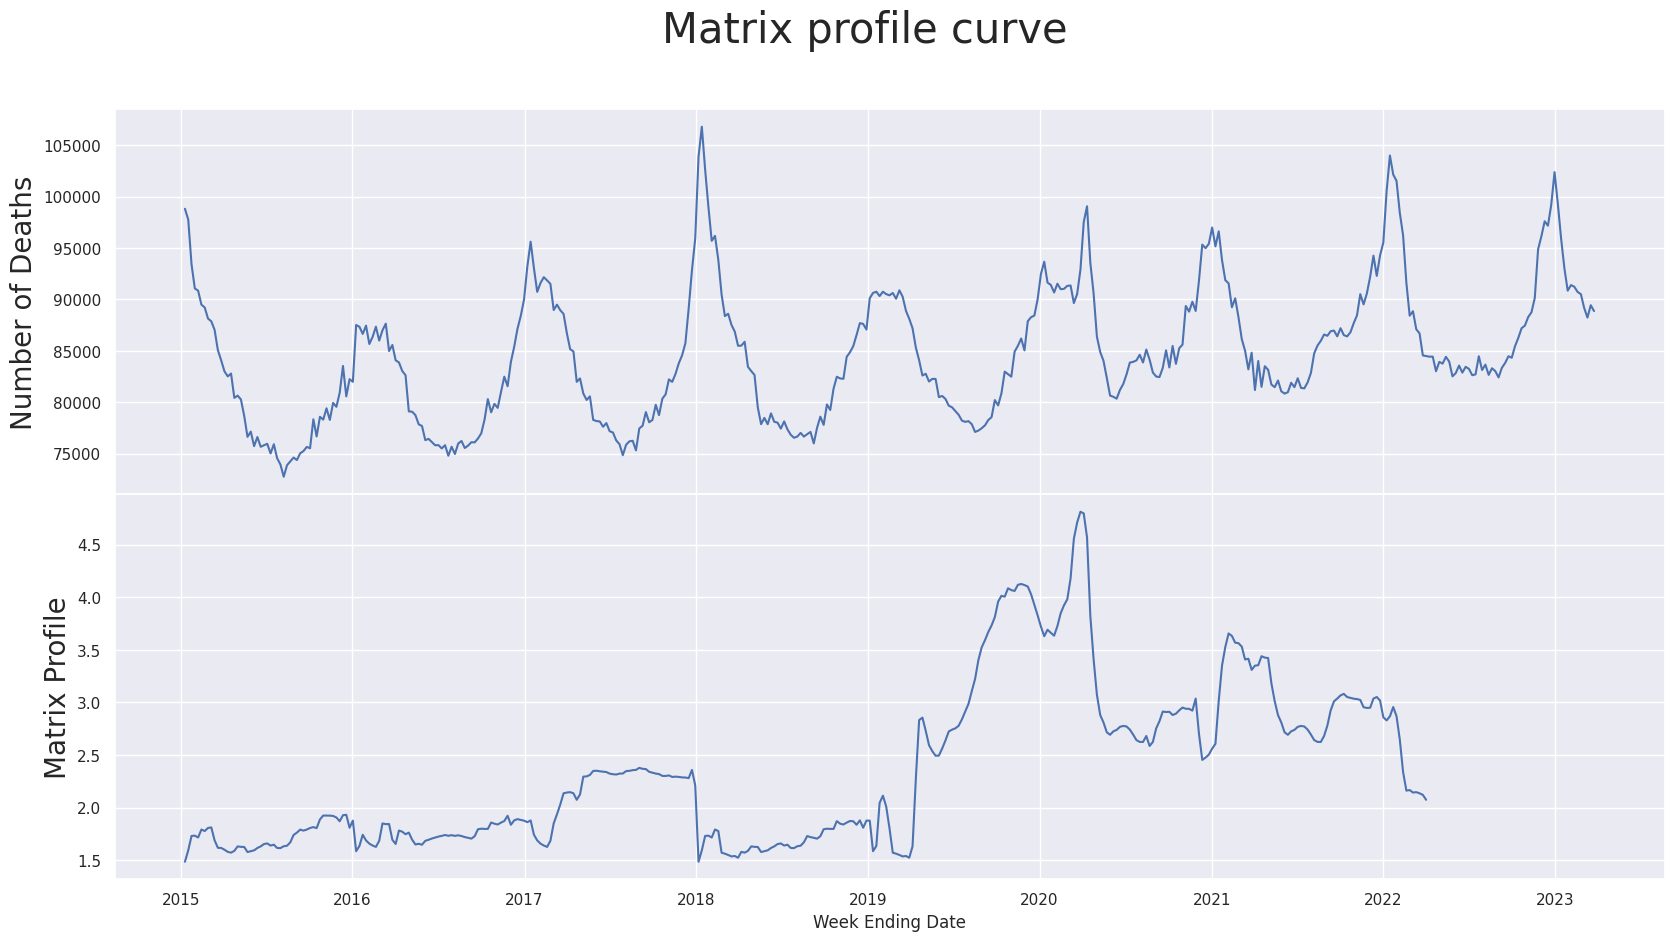

In [29]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Matrix profile curve', fontsize='30')

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
axs[0].set_ylabel('Number of Deaths', fontsize='20')

sns.lineplot(x='Week Ending Date', y=0, data=matrix_profile_df, ax=axs[1])
axs[1].set_ylabel('Matrix Profile', fontsize='20')
plt.show()

## Discord

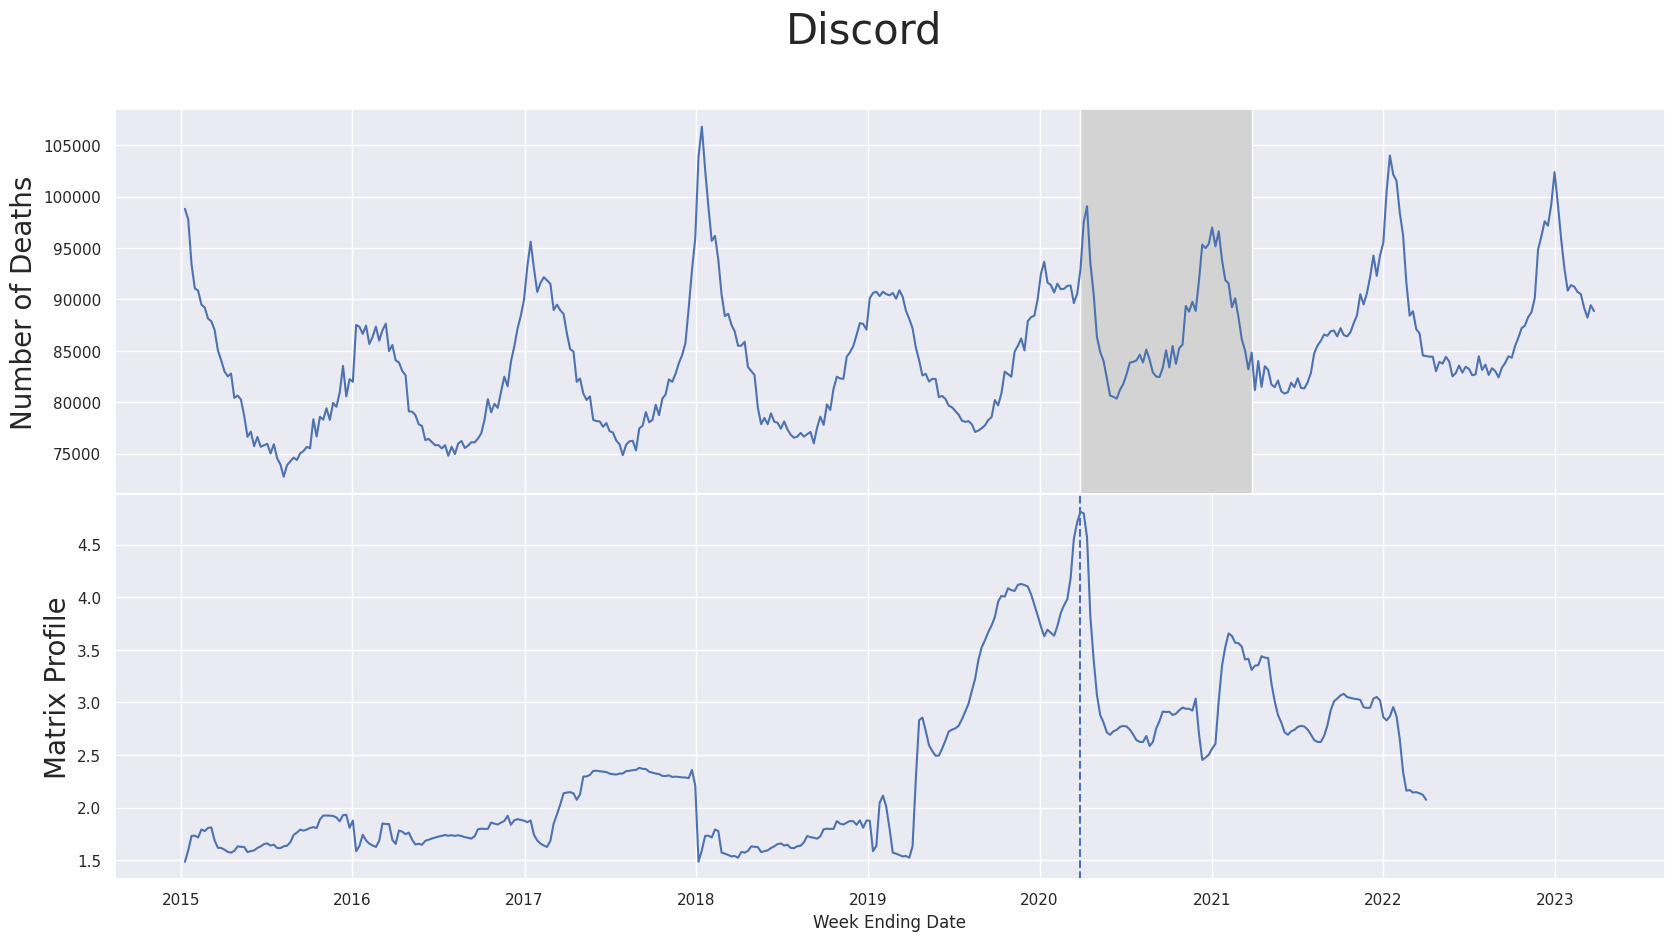

In [30]:
# take the last entry which will be the most different (highest value) segment of our window size
motif_idx = np.argsort(matrix_profile[:, 0])[-1]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord', fontsize='30')

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
axs[0].set_ylabel('Number of Deaths', fontsize='20')

s = mdates.date2num(matrix_profile_df['Week Ending Date'].values[motif_idx])
e = mdates.date2num(matrix_profile_df['Week Ending Date'].values[motif_idx + window_size])
rect = Rectangle((s, 0), e-s, 400000, facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].axvline(x=s, linestyle="dashed")
sns.lineplot(x='Week Ending Date', y=0, data=matrix_profile_df, ax=axs[1])
axs[1].set_ylabel('Matrix Profile', fontsize='20')
plt.show()

# FLUSS

FLUSS stands for Fast Low-cost Unipotent Semantic Segmentation and is a method based on the matrix profile to find regime changes in time-series data.

The idea is to count the number of arcs crossings a each point in the time-series. An arc crossing means that a point behind (respectively ahead) has its minimum distance ahead (respectively behind). The intuition is that a regime change would show up as a point with less arcs crossings, because the similarities will tend to be clustered.

Because as points get to the edge on each side of the time-series have lower possibilities of arc crossings, the count has to be adjusted.

## Calculations

In [31]:
cac, regime_locations = stumpy.fluss(matrix_profile[:, 1], L=window_size, n_regimes=2, excl_factor=1)

In [32]:
cac

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Below we take a look at the actual calculation by the `cac` function and try to understand how it is calculated and reproduce it:

In [33]:
from stumpy.floss import _nnmark, _iac

# compute the nearest neighbor nb of crossings, aka "arc crossings"
ac = _nnmark(matrix_profile[:, 1])

# ideal arc crossings:
iac = _iac(ac.shape[0])
iac[iac == 0.0] = 10**-10  # avoid divide by 0

# naively we get a super high value at the beginning, so this doesn't work:
cac1 = ac / iac

# this looks much better:
cac2 = cac1.copy()
cac2[cac2 > 1.0] = 1.0

# this is how the fluss function does it:
cac3 = cac2.copy()
cac3[: window_size * 1] = 1.0
cac3[-window_size * 1 :] = 1.0

Text(0, 0.5, 'cac')

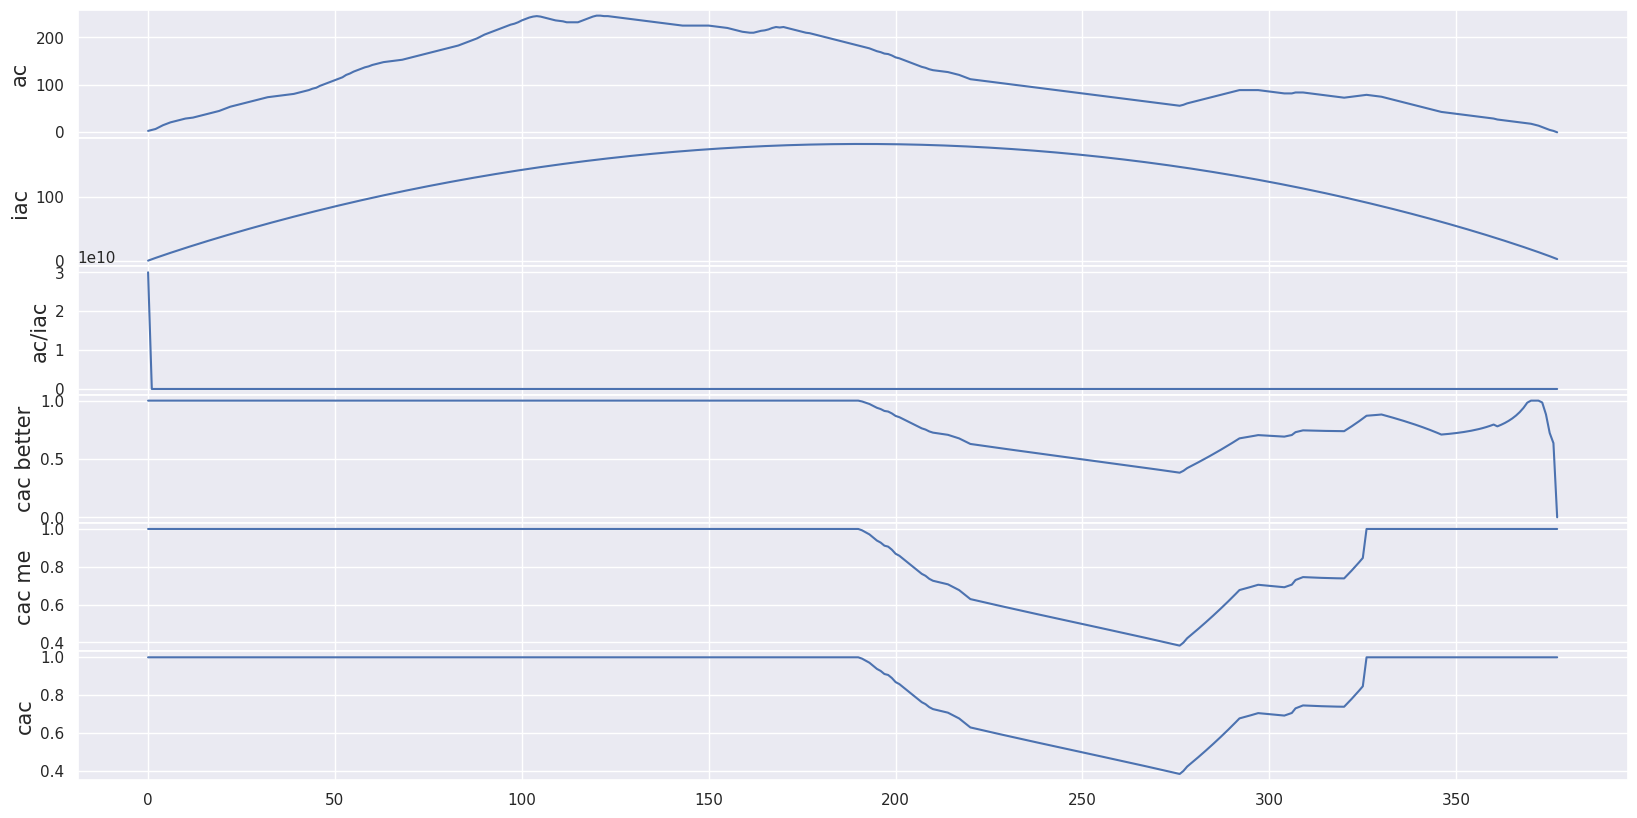

In [34]:
fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(ac)
axs[0].set_ylabel('ac', fontsize='15')

axs[1].plot(iac)
axs[1].set_ylabel('iac', fontsize='15')

axs[2].plot(cac1)
axs[2].set_ylabel('ac/iac', fontsize='15')

axs[3].plot(cac2)
axs[3].set_ylabel('cac better', fontsize='15')

axs[4].plot(cac3)
axs[4].set_ylabel('cac me', fontsize='15')

axs[5].plot(cac)
axs[5].set_ylabel('cac', fontsize='15')

## Regime location

In [35]:
regime_locations

array([276])

In [36]:
regime_locations_dates = matrix_profile_df.iloc[regime_locations]['Week Ending Date']
regime_locations_dates

276   2020-04-25
Name: Week Ending Date, dtype: datetime64[ns]

In [37]:
cac_df = pd.DataFrame(cac)
cac_df['Week Ending Date'] = wc_all.loc[0:(cac_df.shape[0]+1), 'Week Ending Date']
cac_df

,0,Week Ending Date
0,1.0,2015-01-10
1,1.0,2015-01-17
2,1.0,2015-01-24
3,1.0,2015-01-31
4,1.0,2015-02-07
...,...,...
373,1.0,2022-03-05
374,1.0,2022-03-12
375,1.0,2022-03-19
376,1.0,2022-03-26


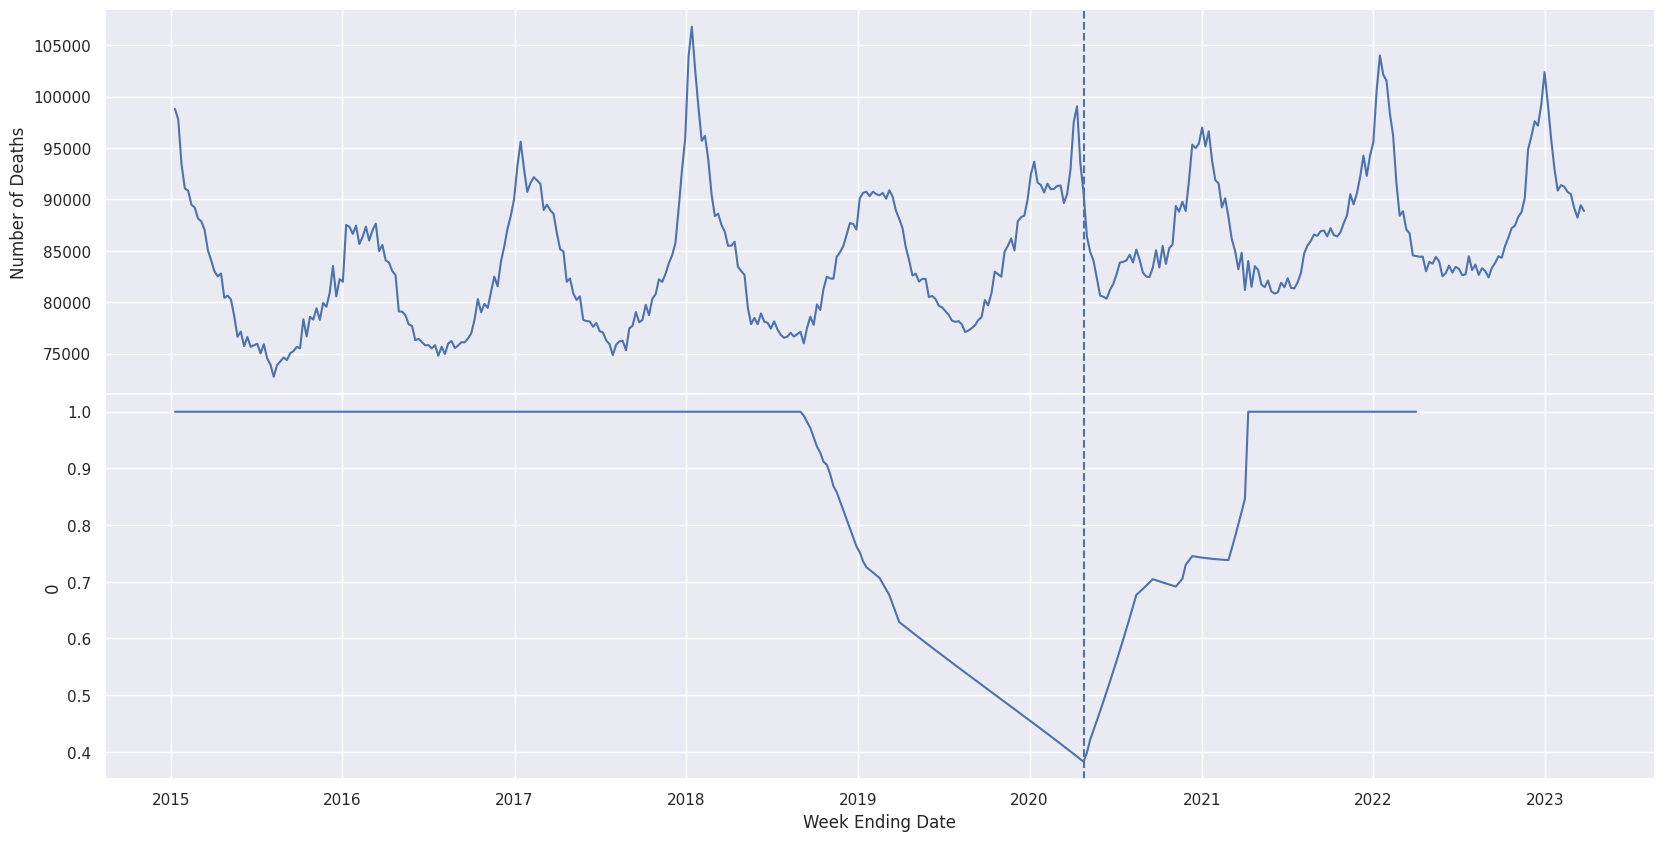

In [40]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

sns.lineplot(x='Week Ending Date', y='Number of Deaths', data=wc_all, ax=axs[0])
sns.lineplot(x='Week Ending Date', y=0, data=cac_df, ax=axs[1])

axs[0].axvline(x=regime_locations_dates.iloc[0], linestyle="dashed")
axs[1].axvline(x=regime_locations_dates.iloc[0], linestyle="dashed")